# Interaction Fingerprint Analysis with ProLIF

In [2]:
!pip install prolif

  Using cached prolif-2.0.3-py3-none-any.whl.metadata (19 kB)
Using cached prolif-2.0.3-py3-none-any.whl (5.1 MB)


In [54]:
import prolif as plf
from rdkit import Chem
import os
import glob

protein_file = str("/home/jovyan/Docking/5F1A_prepped.pdb")

rdkit_prot = Chem.MolFromPDBFile(protein_file, removeHs=False)
protein_mol = plf.Molecule(rdkit_prot)

In [ ]:
# load ligands
poses_path = str(plf.datafiles.datapath / "vina" / "vina_output.sdf")
pose_iterable = plf.sdf_supplier(poses_path)

### PDBQT format

The typical use case here is getting the IFP from AutoDock Vina's output. It requires a few additional steps and informations compared to other formats like MOL2, since the PDBQT format gets rid of most hydrogen atoms and doesn't contain bond order information, which are both needed for ProLIF to work.

:::{important}
Consider using [Meeko](https://github.com/forlilab/Meeko) to prepare your inputs for Vina as it contains some utilities to [convert the output poses](https://github.com/forlilab/Meeko#examples-using-the-command-line-scripts) to the SDF format which is a lot safer than the solution proposed here.
:::

:::{tip}
Do not use OpenBabel to convert your PDBQT poses to SDF, it will not be able to guess the bond orders and charges correctly.
:::

The prerequisites for a successfull usage of ProLIF in this case is having external files that contain bond orders and formal charges for your ligand (like SMILES, SDF or MOL2).

:::{note}
Please note that your PDBQT input must have a single model per file (this is required by `MDAnalysis`). Splitting a multi-model file can be done using the `vina_split` command-line tool that comes with AutoDock Vina: `vina_split --input vina_output.pdbqt`
:::

Let's start by loading our "template" file with bond orders. It can be a SMILES string, MOL2, SDF file or anything supported by RDKit.

In [72]:
test_smiles = [
                      
    'OC1=CC=CC=C1C(O)=O', # Salicylic acid (SAL) 00
    "O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl", #aclofenac 01 
    "O=C(O)C1=CC=NC=C1OC", #sal alt 1, pyridine en methoxy 02 
    "OC1=CC=C2C(C=CC2)=C1C(O)=O", # sal alt 2, met extra ring 03
    "C1=CC=C(C(=C1)C(=O)O)C(=O)O", #phtalic acid 04
    "NC1=CC=CC=C1C(O)=O", #sal alt met N ipv O 05
    "OC1=CC=CC=C1C(N)=O",  #sal alt met C(N)=O ipv C(O)=O 06
    "CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3", #VALDECOXIB met extra N en methylgroep 07
    "CC3=C(c1ccc(S(N)(=O)=O)cc1)C(c2cccnc2)N(C)O3", #VALDECOXIB met extra N" 08
]

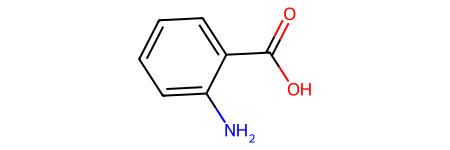

In [78]:
from rdkit import Chem

template = Chem.MolFromSmiles(
    "NC1=CC=CC=C1C(O)=O"
)
template

Next, we'll use the PDBQT supplier which loads each file from a list of paths, and assigns bond orders and charges using the template.

In [80]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
os.chdir('Docking')

# load list of ligands
# pdbqt_files = sorted(plf.datafiles.datapath.glob("vina/*.pdbqt"))
pdbqt_files = sorted(glob.glob('docking_results_ligand_05_pose*.pdbqt'))
pdbqt_files

['docking_results_ligand_05_pose0.pdbqt',
 'docking_results_ligand_05_pose1.pdbqt',
 'docking_results_ligand_05_pose2.pdbqt',
 'docking_results_ligand_05_pose3.pdbqt',
 'docking_results_ligand_05_pose4.pdbqt',
 'docking_results_ligand_05_pose5.pdbqt',
 'docking_results_ligand_05_pose6.pdbqt',
 'docking_results_ligand_05_pose7.pdbqt']

In [81]:
pose_iterable = plf.pdbqt_supplier(pdbqt_files, template)

## Fingerprint generation

We can now generate a fingerprint. By default, ProLIF will calculate the following interactions: Hydrophobic, HBDonor, HBAcceptor, PiStacking, Anionic, Cationic, CationPi, PiCation, VdWContact.
You can list all interactions that are available with the following command:

In [82]:
plf.Fingerprint.list_available()

['Anionic',
 'CationPi',
 'Cationic',
 'EdgeToFace',
 'FaceToFace',
 'HBAcceptor',
 'HBDonor',
 'Hydrophobic',
 'MetalAcceptor',
 'MetalDonor',
 'PiCation',
 'PiStacking',
 'VdWContact',
 'XBAcceptor',
 'XBDonor']

:::{tip}
The default fingerprint will only keep track of the first group of atoms that satisfied the constraints per interaction type and residue pair.

If you want to keep track of all possible interactions to generate a count-fingerprint (e.g. when there are two atoms in the ligand that make an HBond-donor interaction with residue X), use `plf.Fingerprint(count=True)`.
This is also quite useful for visualization purposes as you can then display the atom pair that has the shortest distance which will look more accurate.
This fingerprint type is however a bit slower to compute.
:::

In [83]:
# use default interactions
fp = plf.Fingerprint()
# run on your poses
fp.run_from_iterable(pose_iterable, protein_mol)

  0%|          | 0/8 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7f48134c8c10>

:::{tip}
The `run_from_iterable` method will automatically select residues that are close to the ligand (6.0 Å) when computing the fingerprint. You can modify the 6.0 Å cutoff by specifying `plf.Fingerprint(vicinity_cutoff=7.0)`, but this is only useful if you decide to change the distance parameters for an interaction class (see in the advanced section of the tutorials).

Alternatively, you can pass a list of residues like so:

```python
fp.run_from_iterable(<other parameters>, residues=["TYR38.A", "ASP129.A"])
```
:::

You can save the fingerprint object with `fp.to_pickle` and reload it later with `Fingerprint.from_pickle`:

In [84]:
fp.to_pickle("fingerprint.pkl")
fp = plf.Fingerprint.from_pickle("fingerprint.pkl")

## Analysis

Once the execution is done, you can access the results through `fp.ifp` which is a nested dictionary:

In [55]:
pose_index = 0

While this contains all the details about the different interactions that were detected, it's not the easiest thing to digest.

The best way to analyse our results is to export the interaction fingerprint to a Pandas DataFrame. You can read more about pandas in their
[user_guide](https://pandas.pydata.org/docs/user_guide/index.html).

In [85]:
df = fp.to_dataframe(index_col="Pose")
# show only the 5 first poses
df.head(5)

ligand             UNL1                                                \
protein        TYR348.A               VAL349.A               LEU352.A   
interaction Hydrophobic VdWContact Hydrophobic VdWContact Hydrophobic   
Pose                                                                    
0                  True      False        True       True        True   
1                 False       True       False       True        True   
2                 False      False        True       True        True   
3                 False      False       False       True        True   
4                 False      False       False       True        True   

ligand                                                                 ...  \
protein                   PHE381.A    LEU384.A    TYR385.A             ...   
interaction VdWContact Hydrophobic Hydrophobic Hydrophobic VdWContact  ...   
Pose                                                                   ...   
0                 True       False       False        True      False  ...   
1                False       False       False       False       True  ...   
2                 True       False       False       False      False  ...   
3                 True        True        True        True       True  ...   
4                 True        True        True        True      False  ...   

ligand                                                                 \
protein       TRP387.A    PHE518.A    MET522.A               VAL523.A   
interaction VdWContact Hydrophobic Hydrophobic VdWContact Hydrophobic   
Pose                                                                    
0                 True       False       False       True       False   
1                False        True        True      False        True   
2                 True       False       False       True        True   
3                 True        True        True       True        True   
4                 True        True        True       True        True   

ligand                                                               
protein                  GLY526.A    ALA527.A              SER530.A  
interaction VdWContact VdWContact Hydrophobic VdWContact VdWContact  
Pose                                                                 
0                 True       True        True       True       True  
1                 True      False        True       True       True  
2                 True       True        True       True      False  
3                False       True       False       True       True  
4                 True       True       False       True      False  

[5 rows x 21 columns]

Here are some common pandas snippets to extract useful information from the fingerprint table.

:::{important}
Make sure to remove the `.head(5)` at the end of the commands to display the results for all the frames.
:::

In [ ]:
# hide an interaction type (Hydrophobic)
df.drop("Hydrophobic", level="interaction", axis=1).head(5)

In [58]:
# show only one protein residue (ASP129.A)
df.xs("TRP387.A", level="protein", axis=1).head(5)

ligand             UNL1           
interaction Hydrophobic VdWContact
Pose                              
0                  True       True
1                  True       True
2                 False       True
3                  True      False
4                  True       True

In [59]:
# show only an interaction type (PiStacking)
df.xs("PiStacking", level="interaction", axis=1).head(5)

KeyError: 'PiStacking'

In [57]:
# percentage of poses where each interaction is present
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand             UNL1                                              \
protein        LEU352.A   VAL349.A   ALA527.A   VAL523.A   LEU352.A   
interaction Hydrophobic VdWContact VdWContact VdWContact VdWContact   
%                 100.0      100.0       87.5       87.5       75.0   

ligand                                                                ...  \
protein        VAL523.A   GLY526.A   SER530.A   TRP387.A    TYR385.A  ...   
interaction Hydrophobic VdWContact VdWContact VdWContact Hydrophobic  ...   
%                  75.0       75.0       75.0       75.0        62.5  ...   

ligand                                                                  \
protein        TRP387.A    VAL349.A    MET522.A               PHE518.A   
interaction Hydrophobic Hydrophobic Hydrophobic VdWContact Hydrophobic   
%                  62.5        50.0        50.0       50.0        37.5   

ligand                                                                 
protein       TYR385.A    PHE381.A    LEU384.A    TYR348.A             
interaction VdWContact Hydrophobic Hydrophobic Hydrophobic VdWContact  
%                 37.5        37.5        37.5        25.0       12.5  

[1 rows x 21 columns]

In [ ]:
# same but we regroup all interaction types
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

In [ ]:
# percentage of poses where PiStacking interactions are present, by residue
(
    df.xs("PiStacking", level="interaction", axis=1)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

In [ ]:
# percentage of poses where interactions with PHE330 occur, by interaction type
(
    df.xs("PHE330.B", level="protein", axis=1)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

In [ ]:
# percentage of poses where each interaction type is present
(
    df.T.groupby(level="interaction")
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

In [ ]:
# 10 residues most frequently interacting with the ligand
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("%")
    .T
    * 100
)

You can compute a Tanimoto similarity between poses:

In [ ]:
# Tanimoto similarity between the first frame and the rest
from rdkit import DataStructs

bitvectors = fp.to_bitvectors()
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors)
tanimoto_sims

### Comparing docking poses with a reference ligand

If you have a reference ligand that you wish to use for comparison with your docking poses, you can do so the following way:

:::{important}
Just like for the protein, you reference ligand must contain explicit hydrogens. If the reference comes from a PDB file, you could use PyMOL to add hydrogens to it and export the prepared reference.
:::

In [ ]:
# load the reference
ref = mda.Universe(plf.datafiles.datapath / "vina" / "lig.pdb")
ref_mol = plf.Molecule.from_mda(ref)

# generate IFP for the reference
fp_ref = plf.Fingerprint(fp.interactions)
fp_ref.run_from_iterable([ref_mol], protein_mol)
df_ref = fp_ref.to_dataframe(index_col="Pose")

# set the "pose index" to -1
df_ref.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
df_ref.rename(columns={str(ref_mol[0].resid): df.columns.levels[0][0]}, inplace=True)
df_ref

In [ ]:
# concatenate both dataframes
import pandas as pd

df_ref_poses = (
    pd.concat([df_ref, df])
    .fillna(False)
    .sort_index(
        axis=1,
        level=1,
        key=lambda index: [plf.ResidueId.from_string(x) for x in index],
    )
)
df_ref_poses

We can now calculate the Tanimoto similarity between our reference ligand and the docking poses:

In [ ]:
bitvectors = plf.to_bitvectors(df_ref_poses)
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors[1:])
tanimoto_sims

## Visualisation

There are a few different options builtin when it comes to visualisation.

You can start by plotting the interactions over time:

<Axes: xlabel='Pose'>

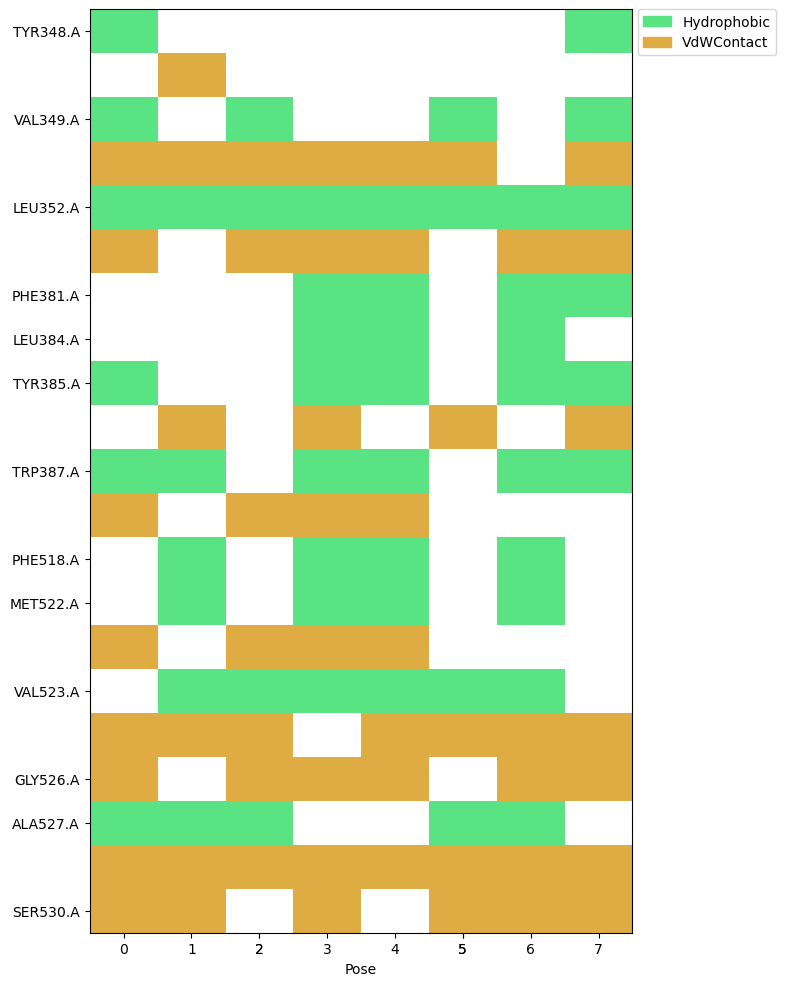

In [86]:
# %matplotlib ipympl

fp.plot_barcode(xlabel="Pose")

:::{tip}
If you uncomment `%matplotlib ipympl` at the top of the above cell, you should be able to see an interactive version of the plot.
:::

You can also display the interactions in a 2D interactive diagram:

In [87]:
fp.plot_lignetwork(pose_iterable[0])

This diagram is interactive, you can:
- zoom and pan,
- move residues around,
- click on the legend to display or hide types of residues or interactions,
- hover an interaction line to display the distance.

:::{note}
It is not possible to export it as an image, but you can always take a screenshot.
:::

You can generate 2 types of diagram with this function, controlled by the `kind` argument:
- `frame`: shows a single specific docking pose (specified with `frame`, corresponds to the `Pose` index in the dataframe).
- `aggregate` (default): the interactions from all poses are grouped and displayed. An optional `threshold` parameter controls the minimum frequency required for an interaction to be displayed (default `0.3`, meaning that interactions occuring in less than 30% of poses will be hidden). The width of interactions is linked to the frequency.

Showing a specific pose:

In [92]:
pose_index = 0
fp.plot_lignetwork(pose_iterable[pose_index], kind="aggregate", frame=pose_index, threshold=0.3)

Up to now we've only been using the default fingerprint generator, but you can optionally enable the `count` parameter to enumerate all occurences of an interaction (the default fingerprint generator will stop at the first occurence), and then display all of them by specifying `display_all=True`:

In [93]:
fp_count = plf.Fingerprint(count=True)
fp_count.run_from_iterable(pose_iterable, protein_mol)
fp_count.plot_lignetwork(
    pose_iterable[pose_index], kind="frame", frame=pose_index, display_all=True
)

  0%|          | 0/8 [00:00<?, ?it/s]

You can also visualize this information in 3D:

In [53]:
view = fp_count.plot_3d(
    pose_iterable[pose_index], protein_mol, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

As in the lignetwork plot, you can hover atoms and interactions to display more information.

The advantage of using a count fingerprint in that case is that it will automatically select the interaction occurence with the shortest distance for a more intuitive visualization.

Once you're satisfied with the orientation, you can export the view as a PNG image with the following snippet:

```python
from IPython.display import Javascript

Javascript(
    """
    var png = viewer_%s.pngURI()
    var a = document.createElement('a')
    a.href = png
    a.download = "prolif-3d.png"
    a.click()
    a.remove()
    """
    % view.uniqueid
)
```

You can also compare two different poses on the same view, and the protein residues that have
different interactions in the other pose or are missing will be highlighted in magenta:

In [49]:
from prolif.plotting.complex3d import Complex3D

pose_index = 0
comp3D = Complex3D.from_fingerprint(
    fp, pose_iterable[pose_index], protein_mol, frame=pose_index
)

pose_index = 4
other_comp3D = Complex3D.from_fingerprint(
    fp, pose_iterable[pose_index], protein_mol, frame=pose_index
)

view = comp3D.compare(other_comp3D)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

You could also superimpose them:

In [50]:
view = comp3D.display()
# other_comp3D will be displayed in green
other_comp3D.LIGAND_STYLE["stick"]["colorscheme"] = "greenCarbon"
other_comp3D._populate_view(view)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.